<a href="https://colab.research.google.com/github/ccfloren-su/Green-Climate-Hero/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bank Marketing Prediction

By: Eliza Estes, Caribel Florentino, Aiden Robinson, Elizabeth Silha

##Introduction

The objective of this machine learning model is to predict whether a client will subscribe to a term deposit for a Portuguese banking institution based on a direct marketing campaign. A term deposit is a fixed-term investment with a financial institution. Banks benefit by reinvesting the deposits for a higher rate of return and clients benefit from interest and a safe method of investing. While general bank marketing techniques are too broad as they do not segment their customer base or require manual segmentation, machine learning can more effectively segment and market to a customer base. These broad marketing approaches can be inefficient and lead to lower conversion rates. By understanding the most important features that impact whether a client will subscribe to a term deposit, banks can more effectively target their marketing efforts to receive a higher rate of deposit. In the long run, this equates to higher profits for banks and interest for clients who are the two main stakeholders for this project.

While this dataset represents demographic information and a history of past campaigns much like other machine learning models, it is novel because it also includes macroeconomic indicators. For example, the employment variation rate which measures how the employment rate changes from quarter to quarter. Also, the number of employees at the time, which indicates a stronger or weaker labor market. Understanding economic conditions at the time of a marketing campaign, can impact whether clients want to make an investment. Therefore, banks can shift their focus to a different segment of clients or delay their marketing campaigns entirely for better outcomes.


##Dataset Overview

The raw dataset contains 45,211 instances and 16 features, including numeric and categorical data. Some feature columns include age, marital status, occupation, education, the month of contact, the outcome of the previous campaign, and the prediction column, whether the client subscribed to a term deposit. Also, there are some null values but we intended to drop the irrelevant columns or rows since there is still a significant amount of data remaining.

The source of this dataset is the UC Irvine Machine Learning Repository donated in 2012 by a Portuguese banking institution. This is a reputable source for datasets used in machine learning research. It is publicly available and has been properly authorized for donation, ensuring that the people who uploaded the datasets had permission and privacy standards were met. All personally identifiable information has been removed to comply with privacy regulations.

Dataset: https://archive.ics.uci.edu/dataset/222/bank+marketing

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #This connects the collab notebook to the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("BigDataPreprocessing") \
    .getOrCreate()

In [ ]:
#Change the file path to your personal path to the data, we are all going to have different ones
#Use Liz's path if its just in your drive
df = spark.read.csv(
    "/content/drive/My Drive/418 Project/bank-additional-full.csv",
    header=True,
    inferSchema=True,
    sep=';'
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data Exploration

In [ ]:
df.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.

In [ ]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



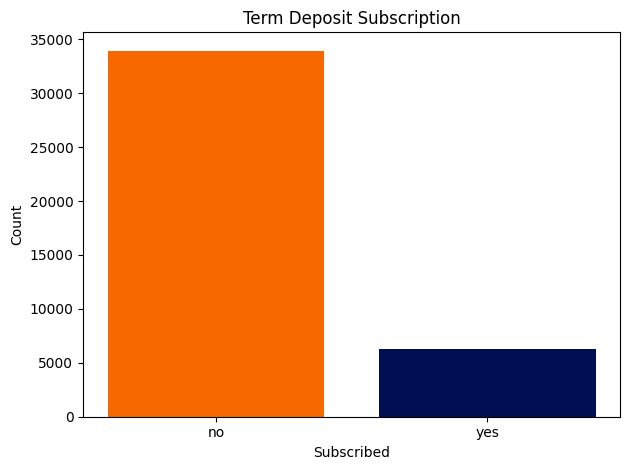

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

#Counts the yes and nos
loan_counts = (
    df.filter(col("loan").isin("yes","no")) #Had to filter there were a couple of unknowns
      .groupBy("loan")
      .count()
      .orderBy("loan")
      .toPandas()
)

#Makes the plot
colors = ["#F76900","#000E54"]
plt.bar(loan_counts["loan"], loan_counts["count"], color=colors)

#Puts labels
plt.title("Term Deposit Subscription")
plt.xlabel("Subscribed")
plt.ylabel("Count")

plt.tight_layout()
plt.show()



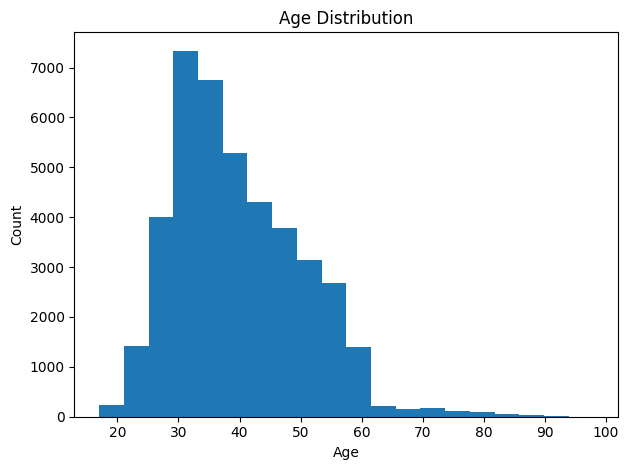

In [ ]:
age_pd = df.select("age").toPandas()

plt.hist(age_pd["age"], bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


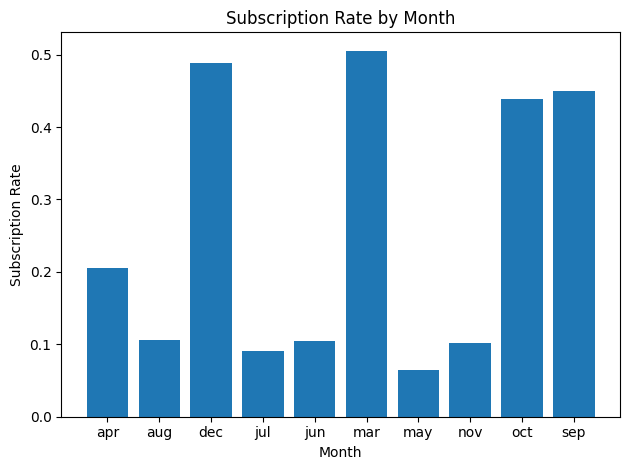

In [ ]:
from pyspark.sql.functions import col, count, when

#Count total and yes counts per month
month_counts = (
    df.groupBy("month")
      .agg(
          count("*").alias("total"),
          count(when(col("y") == "yes", True)).alias("yes_count")
      )
)

#Calculate subscription rate
month_rates = (
    month_counts.withColumn(
        "subscription_rate",
        col("yes_count") / col("total")
    )
    .orderBy("month")
    .toPandas()
)

#Plot
plt.bar(month_rates["month"], month_rates["subscription_rate"])
plt.title("Subscription Rate by Month")
plt.xlabel("Month")
plt.ylabel("Subscription Rate")
plt.tight_layout()
plt.show()

We were then curious to see how many people were reached out to in each month.

*   Target campaigns for: dec, mar, oct, sep
*   Avoid may, it had the highest outreach and some of the lowest rates



In [ ]:
#Calculates subscription rate and total contacts for each month
month_stats = (
    df.groupBy("month")
       .agg(
            count("*").alias("total_contacts")
       )
       .orderBy("month")
)

#Displays subscription rate and contact counts by month
month_stats.show()


+-----+--------------+
|month|total_contacts|
+-----+--------------+
|  apr|          2632|
|  aug|          6178|
|  dec|           182|
|  jul|          7174|
|  jun|          5318|
|  mar|           546|
|  may|         13769|
|  nov|          4101|
|  oct|           718|
|  sep|           570|
+-----+--------------+



Next we were worried why there was no data for jan and feb, but apon investigation we discovered this wasnt an error or mistake. The bank does not campaign during these months so there are simply no records.

In [ ]:
df.groupBy("month").count().orderBy("month").show(20)


+-----+-----+
|month|count|
+-----+-----+
|  apr| 2632|
|  aug| 6178|
|  dec|  182|
|  jul| 7174|
|  jun| 5318|
|  mar|  546|
|  may|13769|
|  nov| 4101|
|  oct|  718|
|  sep|  570|
+-----+-----+



##Data Preprocessing

We dropped duration as you can't predict the duration of a call before it happens. Therefore it wont help our models. We also felt contact was irrelevant, as it would not really matter whether its a mobile or home phone.

In [ ]:
df = df.drop('duration', 'contact') #drops duration and contact columns

Encode categorical features (StringIndexer + OneHotEncoder)

Normalize numerical values if needed (especially for LR)

Split into train/test stratified on y

In [ ]:
from pyspark.ml.feature import StringIndexer
label_indexer = StringIndexer(inputCol="y", outputCol="label")
df = label_indexer.fit(df).transform(df)

In [ ]:
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "month", "poutcome", 'day_of_week']

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder

stages = []
for cat in categorical_cols:
    # StringIndexer transforms the string values into numeric indices.
    indexer = StringIndexer(inputCol=cat, outputCol=cat + "_Index", handleInvalid="keep")
    # OneHotEncoder transforms the indices into one-hot encoded vectors.
    encoder = OneHotEncoder(inputCols=[cat + "_Index"], outputCols=[cat + "_Vec"])
    stages += [indexer, encoder]

In [ ]:
# Create and fit a Pipeline on your DataFrame
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)
df2 = pipeline_model.transform(df)

In [ ]:
df2 = (df2
    .withColumnRenamed("emp.var.rate",   "emp_var_rate")
    .withColumnRenamed("cons.price.idx", "cons_price_idx")
    .withColumnRenamed("cons.conf.idx",  "cons_conf_idx")
    .withColumnRenamed("nr.employed",    "nr_employed")
)

In [ ]:
features_list = [
    "age", "campaign", "pdays", "previous",
    "emp_var_rate", "cons_price_idx", "cons_conf_idx",
    "euribor3m", "nr_employed",
    "job_Vec", "marital_Vec", "education_Vec",
    "default_Vec", "housing_Vec", "loan_Vec",
    "month_Vec", "poutcome_Vec"
]


In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features_list, outputCol="features")
df2 = assembler.transform(df2)

In [ ]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
df2 = scaler.fit(df2).transform(df2)

In [ ]:
train, test = df2.randomSplit([0.8, 0.2], seed=42)

In [ ]:
df2.show()

+---+-----------+--------+-------------------+-------+-------+----+-----+-----------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+-----+---------+--------------+-------------+-------------+---------------+-------------+-------------+-------------+-------------+-------------+----------+-------------+-----------+--------------+--------------+-------------+-----------------+---------------+--------------------+--------------------+
|age|        job| marital|          education|default|housing|loan|month|day_of_week|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|label|job_Index|       job_Vec|marital_Index|  marital_Vec|education_Index|education_Vec|default_Index|  default_Vec|housing_Index|  housing_Vec|loan_Index|     loan_Vec|month_Index|     month_Vec|poutcome_Index| poutcome_Vec|day_of_week_Index|day_of_week_Vec|            features|      scaledFeatures|
+---+-----------

##Unsupervised Models

###Clustering - All Data

The Model + identifying top 5 features

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd

#Training KMeans
k = 2
kmeans = KMeans(
    featuresCol="scaledFeatures",
    k=k,
    seed=42
)
km_model = kmeans.fit(df2)

predictions_km = km_model.transform(df2)
evaluator = ClusteringEvaluator(
    featuresCol="scaledFeatures",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)
silhouette = evaluator.evaluate(predictions_km)
print(f"Silhouette score = {silhouette:.4f}")

centers = km_model.clusterCenters()

meta = df2.schema["features"].metadata["ml_attr"]["attrs"]
attrs = []
for group in meta.values():
    attrs += group
attrs_sorted = sorted(attrs, key=lambda x: x["idx"])
feature_names = [a["name"] for a in attrs_sorted]

centers_df = pd.DataFrame(centers, columns=feature_names)
print("Cluster centers (first few columns):")
print(centers_df.iloc[:, :5])  # show first 5 features

#For each cluster, it shows the top 5 distinguishing features
for cid, row in centers_df.iterrows():
    top5 = row.abs().sort_values(ascending=False).head(5)
    print(f"\nCluster {cid} top 5 features:")
    print(top5)


Silhouette score = 0.1728
Cluster centers (first few columns):
        age  campaign     pdays  previous  emp_var_rate
0  3.843956  0.924694  5.149041  0.349723      0.051020
1  3.824974  0.937387  5.150977  0.348400      0.057306

Cluster 0 top 5 features:
cons_price_idx    161.660207
nr_employed        71.512959
cons_conf_idx       8.746662
pdays               5.149041
age                 3.843956
Name: 0, dtype: float64

Cluster 1 top 5 features:
cons_price_idx    161.662787
nr_employed        71.522044
cons_conf_idx       8.772871
pdays               5.150977
age                 3.824974
Name: 1, dtype: float64


The accuracy and f1 score

In [ ]:
from pyspark.sql.functions import row_number, when
from pyspark.sql.window    import Window
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions_km = km_model.transform(df2)

cluster_counts = (
    predictions_km
      .groupBy("prediction", "y")
      .count()
)
window = Window.partitionBy("prediction").orderBy(col("count").desc())
majority_df = (
    cluster_counts
      .withColumn("rn", row_number().over(window))
      .filter(col("rn") == 1)
      .select("prediction", "y")
)
mapping = {row['prediction']: row['y'] for row in majority_df.collect()}

pred_labeled = predictions_km.withColumn(
    "predicted_label",
    when(col("prediction") == 0, mapping[0])
    .otherwise(mapping[1])
)

indexer = StringIndexer(
    inputCols=["y", "predicted_label"],
    outputCols=["trueIndex", "predIndex"]
).fit(pred_labeled)
pred_indexed = indexer.transform(pred_labeled)

e_acc = MulticlassClassificationEvaluator(
    labelCol="trueIndex", predictionCol="predIndex", metricName="accuracy"
)
e_f1 = MulticlassClassificationEvaluator(
    labelCol="trueIndex", predictionCol="predIndex", metricName="f1"
)
acc = e_acc.evaluate(pred_indexed)
f1  = e_f1.evaluate(pred_indexed)

print(f"Clustering‐based accuracy: {acc:.4f}")
print(f"Clustering‐based F1 score: {f1:.4f}")


Clustering‐based accuracy: 0.8873
Clustering‐based F1 score: 0.8344


##Supervised Models

###Decision Tree - All Data

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.functions import vector_to_array

#Adding class weights
counts = dict(df2.groupBy("label").count()
                  .rdd.map(lambda r: (r["label"], r["count"])).collect())

majority = max(counts, key=counts.get)
minority = min(counts, key=counts.get)
ratio = counts[majority] / counts[minority]

df_weighted = df2.withColumn(
    "classWeightCol",
    when(col("label") == minority, ratio).otherwise(1.0)
)

dt_weighted = DecisionTreeClassifier(
    featuresCol="scaledFeatures",
    labelCol="label",
    weightCol="classWeightCol",
    maxDepth=5
)
dtw_model = dt_weighted.fit(df_weighted)

test_weighted = test.withColumn(
    "classWeightCol",
    when(col("label") == minority, ratio).otherwise(1.0)
)
preds_w = dtw_model.transform(test_weighted)

F1 Score, AUC, Accuracy, Recall

In [ ]:
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)

accuracy_w = acc_evaluator.evaluate(preds_w)
f1_w       = f1_evaluator.evaluate(preds_w)
auc_w      = auc_evaluator.evaluate(preds_w)
rec_w = recall_evaluator.evaluate(preds_w)

print(f"Weighted Model Accuracy: {accuracy_w:.4f}")
print(f"Weighted Model F1 Score: {f1_w:.4f}")
print(f"Weighted Model AUC: {auc_w:.4f}")
print(f"Weighted Model Recall: {rec_w:.4f}")

Weighted Model Accuracy: 0.8127
Weighted Model F1 Score: 0.8375
Weighted Model AUC: 0.7874
Weighted Model Recall: 0.8127


Top Features by Importance

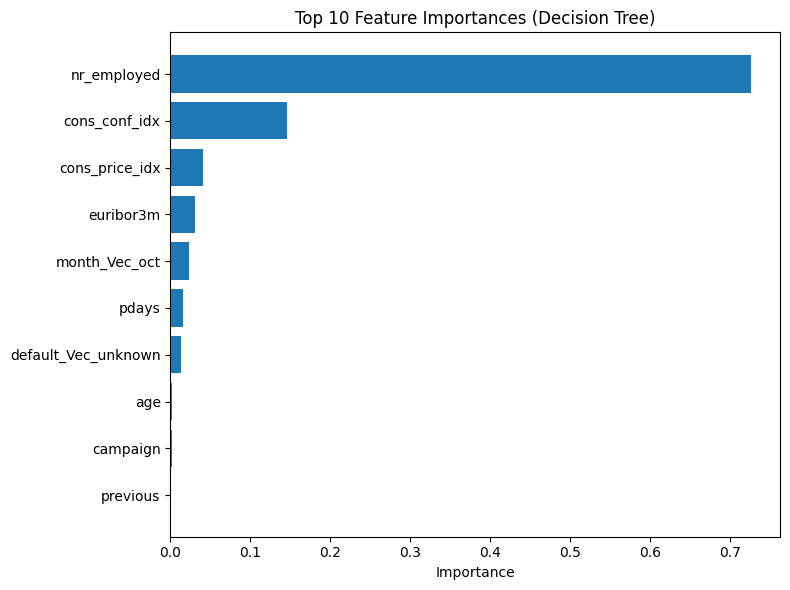

In [ ]:
importances = dtw_model.featureImportances.toArray().tolist()

meta = df_weighted.schema["features"].metadata["ml_attr"]["attrs"]
attrs = []
for group in meta.values():
    attrs.extend(group)

attrs_sorted = sorted(attrs, key=lambda x: x["idx"])
feature_names = [a["name"] for a in attrs_sorted]

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

top10 = fi_df.sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8, 6))
plt.barh(top10["feature"][::-1], top10["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()

###Logistic Regression - All Data Except Econ

With this model we decided to test a dataset of everything except the economical features as they were driving our other models.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

# Drop just econ variables + the known leakage columns
df3 = df2.drop("emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed", "pdays", "poutcome", 'weight')

# Define the non-economic features — ALL numeric columns except the econ variables and label
all_feats = [
    c for c, t in df3.dtypes
    if t in ("double","int","float","long") and c != "label"
]

# Assemble features
assembler = VectorAssembler(inputCols=all_feats, outputCol="features_non_econ")
df3 = assembler.transform(df3)

# Split into train/test sets
train_non, test_non = df3.randomSplit([0.7,0.3], seed=42)

# Fit Logistic Regression
lr = LogisticRegression(
    labelCol="label",
    featuresCol="features_non_econ",
    maxIter=20,
    regParam=0.1
)
lrModel = lr.fit(train_non)

# Make predictions
preds_lr = lrModel.transform(test_non)


In [ ]:
#Show confusion matrix
preds_lr.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0| 1340|
|  0.0|       0.0|10843|
|  1.0|       1.0|   42|
|  0.0|       1.0|   20|
+-----+----------+-----+



Top coefficients

In [ ]:
#Print top 10 non-economic coefficients
coef_pairs = list(zip(all_feats, lrModel.coefficients))
top10 = sorted(coef_pairs, key=lambda x: abs(x[1]), reverse=True)[:10]
print("Top 10 Non-Econ Feature Coefficients:")
for name, coef in top10:
    print(f"  {name:25s} : {coef:+.4f}")


Top 10 Non-Econ Feature Coefficients:
  poutcome_Index            : +0.5302
  default_Index             : -0.2923
  previous                  : +0.2621
  month_Index               : +0.1283
  marital_Index             : +0.0352
  housing_Index             : -0.0307
  campaign                  : -0.0296
  job_Index                 : +0.0240
  education_Index           : -0.0111
  day_of_week_Index         : -0.0057


Evaluate Accuracy F1 Precision Recall AUC

In [ ]:
# Calculate Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
acc = evaluator_acc.evaluate(preds_lr)
print(f"Accuracy: {acc:.4f}")

# Calculate F1 score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)
f1 = evaluator_f1.evaluate(preds_lr)
print(f"F1 Score: {f1:.4f}")

# Calculate Precision
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
)
prec = evaluator_prec.evaluate(preds_lr)
print(f"Precision: {prec:.4f}")

# Calculate Recall
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
)
rec = evaluator_rec.evaluate(preds_lr)
print(f"Recall: {rec:.4f}")

# Calculate AUC
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
auc = evaluator_auc.evaluate(preds_lr)
print(f"AUC: {auc:.4f}")


Accuracy: 0.8889
F1 Score: 0.8414
Precision: 0.8660
Recall: 0.8889
AUC: 0.7277


Creates visual

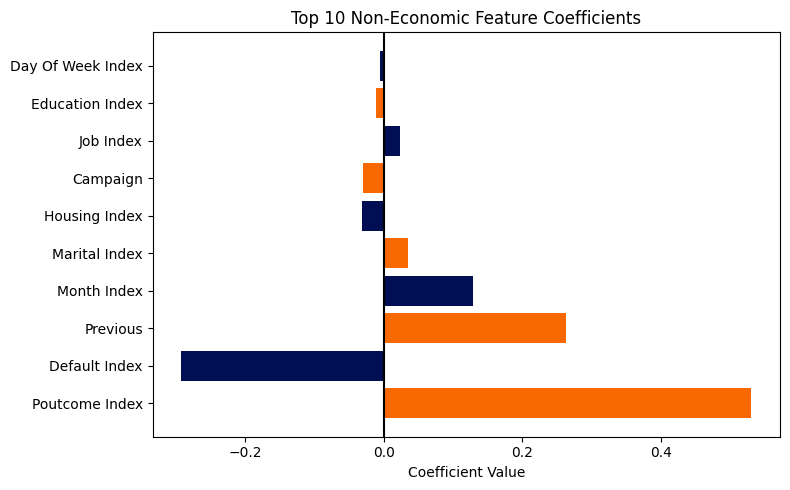

In [ ]:
# Extract top feature coefficients
coef_pairs = list(zip(all_feats, lrModel.coefficients))
top10 = sorted(coef_pairs, key=lambda x: abs(x[1]), reverse=True)[:10]
labels, values = zip(*top10)

# Make labels readable
display_labels = [lbl.replace("_", " ").title() for lbl in labels]

plt.figure(figsize=(8,5))
bars = plt.barh(display_labels, values, color=colors)
plt.axvline(0, color="black")
plt.title("Top 10 Non-Economic Feature Coefficients")
plt.xlabel("Coefficient Value")

plt.tight_layout()
plt.show()


###Random Forest - All Data

In [ ]:
#dealing with dataset imbalance

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Step 1: Get class distribution
label_counts = df2.groupBy("label").count().collect()
count_dict = {row['label']: row['count'] for row in label_counts}
majority = max(count_dict.values())
class_weights = {label: majority / count for label, count in count_dict.items()}

# Step 2: Define and apply UDF
def calc_weight(label):
    return float(class_weights[label])

weight_udf = udf(calc_weight, DoubleType())
df2 = df2.withColumn("weight", weight_udf("label"))


In [ ]:
train, test = df2.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="scaledFeatures", labelCol="label",
    weightCol="weight", numTrees=55, seed=42
)
rf_model = rf.fit(train)

Evaluate Accuracy F1 Precision Recall AUC

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

predictions = rf_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

#outputs model accuracy
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

#outputs model AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

#calculate confusion matrix
pred_rdd = predictions.select("prediction", "label").rdd.map(tuple)
metrics = MulticlassMetrics(pred_rdd)

cm = metrics.confusionMatrix()
print("Confusion Matrix:")
print(cm)

#outputs precision, recall, and F1 scores
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1 = metrics.fMeasure(1.0)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy: 0.8323
AUC: 0.7933


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[6239., 1051.],
             [ 326.,  595.]])
Precision: 0.3615
Recall:    0.6460
F1 Score:  0.4636


In [ ]:
#looking at feature importance

final_features = assembler.getInputCols()

importances = rf_model.featureImportances

feature_importance_list = list(zip(final_features, importances))

sorted_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")


Feature Importances:
housing_Index: 0.2101
loan_Index: 0.1647
marital_Index: 0.1602
default_Index: 0.1113
previous: 0.0547
education_Index: 0.0379
age: 0.0125
campaign: 0.0017
job_Index: 0.0017
poutcome_Index: 0.0013
month_Index: 0.0001
day_of_week_Index: 0.0001


###Gradient Boosting - Econ Data

Tested many different parameter combinations, the selected yielded the highest results.

####Here were some of the other combos:

* maxIter=30, maxDepth=4, stepSize=0.05 → AUC: 0.7959
* maxIter=30, maxDepth=4, stepSize=0.1 → AUC: 0.7962
*maxIter=30, maxDepth=5, stepSize=0.05 → AUC: 0.7962
*maxIter=30, maxDepth=5, stepSize=0.1 → AUC: 0.7970
*maxIter=30, maxDepth=6, stepSize=0.05 → AUC: 0.7974
*maxIter=30, maxDepth=6, stepSize=0.1 → AUC: 0.7975
*maxIter=50, maxDepth=4, stepSize=0.05 → AUC: 0.7960
*maxIter=50, maxDepth=4, stepSize=0.1 → AUC: 0.7978
*maxIter=50, maxDepth=5, stepSize=0.05 → AUC: 0.7969
*maxIter=50, maxDepth=5, stepSize=0.1 → AUC: 0.7972
*maxIter=50, maxDepth=6, stepSize=0.05 → AUC: 0.7974
*maxIter=50, maxDepth=6, stepSize=0.1 → AUC: 0.7978
*maxIter=70, maxDepth=4, stepSize=0.05 → AUC: 0.7952
*maxIter=70, maxDepth=4, stepSize=0.1 → AUC: 0.7967
*maxIter=70, maxDepth=5, stepSize=0.05 → AUC: 0.7968
*maxIter=70, maxDepth=5, stepSize=0.1 → AUC: 0.7972
*maxIter=70, maxDepth=6, stepSize=0.05 → AUC: 0.7973
*maxIter=70, maxDepth=6, stepSize=0.1 → AUC: 0.7977

####Builds the model
This is the base model trained on all data

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Trains the model
gbt = GBTClassifier(
    labelCol="label",
    featuresCol="features",  #used unscaled features cause tree based model
    maxIter=70,
    maxDepth=4,
    stepSize=0.05
)

#Fits model
gbt_model = gbt.fit(train)
predictions = gbt_model.transform(test)

We chose to use AUC due to the imbalance in our dataset.

In [ ]:
#Evaluates the AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.7993


In [ ]:
predictions.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  205|
|  0.0|       1.0|  118|
|  1.0|       0.0|  716|
|  0.0|       0.0| 7172|
+-----+----------+-----+



In [ ]:
predictions.select("label", "prediction", "probability").show(10, truncate=False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.9311517127000285,0.0688482872999715] |
|0.0  |0.0       |[0.7563298130012258,0.24367018699877419]|
|1.0  |0.0       |[0.7563298130012258,0.24367018699877419]|
|0.0  |0.0       |[0.7308763108325717,0.26912368916742835]|
|1.0  |0.0       |[0.7956525527780742,0.20434744722192577]|
|0.0  |0.0       |[0.8612143409774629,0.13878565902253714]|
|0.0  |0.0       |[0.8648620002784477,0.13513799972155227]|
|0.0  |0.0       |[0.9283753178783005,0.07162468212169948]|
|0.0  |0.0       |[0.5480582175562387,0.45194178244376126]|
|0.0  |0.0       |[0.8306011901913654,0.16939880980863464]|
+-----+----------+----------------------------------------+
only showing top 10 rows



Used same parameters as earlier model but now set to only use the economic variables

In [ ]:
econ_cols = ["emp_var_rate","cons_price_idx","cons_conf_idx","euribor3m","nr_employed"]

#Only the economic variables into a new column
assembler = VectorAssembler(inputCols=econ_cols, outputCol="econFeatures")
df_econ = assembler.transform(df2)

#Split into train and test sets
train, test = df_econ.randomSplit([0.7, 0.3], seed=42)

#Fit GBTClassifier on econFeatures
gbt = GBTClassifier(
    labelCol="label",
    featuresCol="econFeatures",
    maxIter=70,
    maxDepth=4,
    stepSize=0.05,
    seed=42
)
model = gbt.fit(train)
preds = model.transform(test)

AUC of econ model

In [ ]:
#Evaluate AUC
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc = evaluator.evaluate(preds)
print(f"AUC: {auc:.4f}")

AUC: 0.7955


Feature importance

In [ ]:
#Print feature importances
imps = model.featureImportances.toArray()
print("\nFeature importances:")
for name, score in sorted(zip(econ_cols, imps), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.4f}")


Feature importances:
  nr_employed         : 0.4626
  emp_var_rate        : 0.2093
  euribor3m           : 0.1359
  cons_conf_idx       : 0.1209
  cons_price_idx      : 0.0712


Accuracy F1 Precision Recall

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Calculate accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
acc = evaluator_acc.evaluate(preds)
print(f"Accuracy: {acc:.4f}")

#Calculate F1 score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)
f1 = evaluator_f1.evaluate(preds)
print(f"F1 Score: {f1:.4f}")

#Calculate Precision
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
)
prec = evaluator_prec.evaluate(preds)
print(f"Precision: {prec:.4f}")

#Calculate Recall
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
)
rec = evaluator_rec.evaluate(preds)
print(f"Recall: {rec:.4f}")


Accuracy: 0.8906
F1 Score: 0.8662
Precision: 0.8639
Recall: 0.8906


In [ ]:
#Renaming the cols so theyre more interpretable
display_labels = ["Employment Variation Rate (%)",
                  "Consumer Price Index",
                  "Consumer Confidence Index",
                  "3-Month Euribor Rate (%)",
                  "Number Employed"]

# econ cols and display labels
for col, label in zip(econ_cols, display_labels):
    corr = df_econ.stat.corr("label", col)
    print(f"{label:25s} corr = {corr:+.2f}")


Employment Variation Rate (%) corr = -0.30
Consumer Price Index      corr = -0.14
Consumer Confidence Index corr = +0.05
3-Month Euribor Rate (%)  corr = -0.31
Number Employed           corr = -0.35


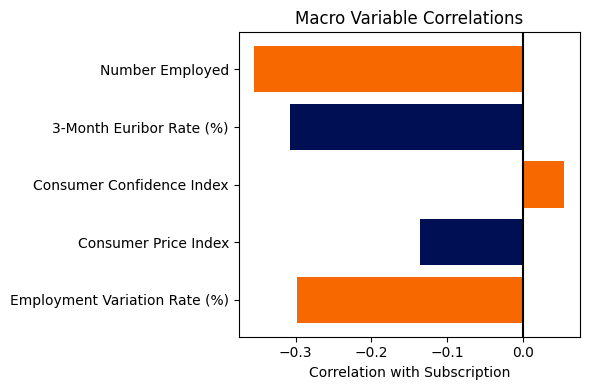

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

corrs = [df_econ.stat.corr("label", c) for c in econ_cols]

#Picking syracuse colors and then making it so that it will select every other one so blue orange blue orange etc
orange = "#F76900"; blue = "#000E54"
colors = [orange if i%2==0 else blue for i in range(len(corrs))]

plt.figure(figsize=(6,4))
bars = plt.barh(display_labels, corrs, color=colors)
plt.axvline(0, color="black")

plt.xlabel("Correlation with Subscription")
plt.title("Macro Variable Correlations")

plt.tight_layout()
plt.show()